## Section 9: Applications of Principal Component Analysis with NumPy and SciPy


### Applications of PCA

In the previous section, we discussed what principal component analysis is and how to perform it.  

To review, PCA finds an orthonormal basis for the k-dimensional subspace (k $\le$ K) in a matrix of full-rank K that maximizes the sum-of-squares of the projected data.  PCA allows you to identify patterns/correlations that explain said data and compare their importance.

To perform PCA from scratch on your data, there are a number of steps: 1) mean-center the data ($\bar{x}$= $x$-mean($x$)), 2) compute the covariance matrix (cov_mat = $\bar{x}^{T}$$\bar{x}$), 3) eigen-decompose the covariance matrix to get the eigenvalues ($\Lambda$) and eigenvectors ($V$), 4) sort the eigenvalues and eigenvectors from largest to smallest, 5) select the number of principal components to retain, compute the principal components ($PC$ = $\bar{x}$ * $V$) , 6) reconstruct the data with your principal components using the inverse transform ($\bar{x}est$ = $PC$*$V^{T}$ + mean($x$)). 

There are a ton of applications to PCA.  I will focus on just a few of them here.

Often, PCA is used within the context of machine learning (in ML jargon it is "an unsupervised learning" method), so a common package used to implement PCA in data science (and used in many commonly-found tutorials for PCA applications) is ``scikit-learn``.  While this package is great, it sweeps a lot of the details of how PCA is done under the rug and is a bit "black box"-y.   

So in the following examples of PCA applications, I will show you how to perform this analysis from first principles, just with NumPy and SciPy linear algebra routines.   In the first case, I will also list the companion source codes to perform the same analysis using scikit-learn.


### 1. Face Recognition


PCA can be used as a sort of engine to do face recognition (this may be covered later under machine learning in November ... time permitting).  For now, we will simply demonstrate its ability to extract key properties of people's faces that, "by eye", are good enough for identification.   We will use the "Labeled Faces in the Wild" dataset, which consists of several thousand collated photos of various public figures. A fetcher for the dataset is built into Scikit-Learn: each image has dimensions of [62×47] or 2,914 pixels total.

The source code for this exercise is in ``eigenfaces_np.py``.  The companion source code for the scikit-learn version is ``eigenfaces_sklearn.py``.


To start, let's import the libraries needed for this example: NumPy (to do stuff), Matplotlib (to display stuff), and scikit-learn (package name is "sklearn"; to load in the data).

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8] #to make the figures larger in Jupyter

from sklearn.datasets import fetch_lfw_people

The Python function used to perform PCA on this data set is called ``run``.  The first three lines of this function start as follows:

```
def run(numpca=150):

 faces = fetch_lfw_people(min_faces_per_person=60)
 print(faces.images.shape)

```

The first line sets a variable ``numpca``, which we can adjust to our liking when we run the program (note, as written, it will crash if we used fewer than 24 PCs).    The default value is set at 150 principal components, for reasons that will become clearer in a second.

We then "fetch" the subset of the people for whom we have at least 60 different images.

The "print" statement tells us the dimensionality of our data: we have 1348 separate images and 2,914 (62x47) pixels per image.   This is a _very_ high-dimensional data set.

Then, we go through our steps for performing PCA with eigendecomposition:

```
#Step 1: mean-subtract each image
 faces_mean=faces.data-np.mean(faces.data,axis=0)

#Step 2: compute the covariance for the images
 cov=np.matmul(faces_mean.T,faces_mean)

#Step 3: derive eigenvalues, eigenvectors
 eig_val,eig_vec=np.linalg.eigh(cov)

#Step 4: sort
 indices=np.argsort(eig_val)[::-1]
 eig_val=eig_val[indices]
 eig_vec=eig_vec[:,indices]

#Step 5: truncate to requested number of principal components, compute PCs
 n_comp=numpca
 eig_vec=eig_vec[:,:n_comp]
 eig_valtot=eig_val
 eig_val=eig_val[:n_comp]

 pca_components=((faces_mean).dot(eig_vec))
```


Then next blocks of code do some plotting for us, so we can understand the data a bit better.

In particular we are going to plot the eigenvectors derived from eigendecomposition of these data.   Since each individual eigenvector has the dimensions of a single image and each original image is that of a face, the displayed images are often called "eigenfaces".

Below, again, we break up ``run`` into some sections ...


(1348, 62, 47)


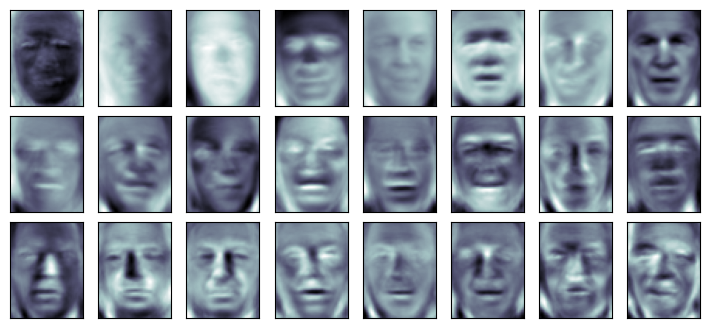

In [13]:
 numpca=150
    
 faces = fetch_lfw_people(min_faces_per_person=60)
 print(faces.images.shape)
# print(faces.target_names)

#Step 1
 faces_mean=faces.data-np.mean(faces.data,axis=0)

#Step 2
 cov=np.matmul(faces_mean.T,faces_mean)

#Step 3
 eig_val,eig_vec=np.linalg.eigh(cov)

#Step 4
 indices=np.argsort(eig_val)[::-1]
 eig_val=eig_val[indices]
 eig_vec=eig_vec[:,indices]

#Step 5
 n_comp=numpca
 eig_vec=eig_vec[:,:n_comp]
 eig_valtot=eig_val
 eig_val=eig_val[:n_comp]

 pca_components=((faces_mean).dot(eig_vec))


### Plotting the Eigenvectors
 fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                          subplot_kw={'xticks':[], 'yticks':[]},
                          gridspec_kw=dict(hspace=0.1, wspace=0.1))
 for i, ax in enumerate(axes.flat):
     ax.imshow(eig_vec[:,i].reshape(62,47),cmap='bone')


 plt.show()

############

The results give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later vectors seem to be picking out certain features, such as eyes, noses, and lips. 

So we have performed PCA on this giant data set of faces and now have a bunch of "eigenfaces" (eigenvectors).   How much of the variance does each "eigenface" contribute to the total variance?  The relative value of the eigenvalues give us the answer.  

In other words, for the $k-th$ principal component, the "explained variance ratio" is ...


$\Large{ratio_{k}}$ = $\Large{\frac{\Lambda_{k}}{\sum_{i=0,K} \Lambda_{i} }}$ 


Calculating that is relatively straightforward if you know the right NumPy functions.  In our implementation, we save all of the eigenvalues (prior to truncation by _numpca_) to a variable ``eig_valtot``.

The total variance is then ``totvar = np.sum(eig_valtot)``.  And the explained variance ratio is then ``explained_var_ratio = eigval_tot/totvar``.  We can then calculate the _cumulative_ variance of each eigenvector/PC using the NumPy function ``np.cumsum([variable])``.

In [14]:
 ### Plotting the contribution of each PC to the total variance
 totvar=np.sum(eig_valtot)

 explained_var_ratio=eig_valtot/totvar

#Computing the Cumulative Variance of each eigenvector/PC

 cumul_sum_eigval=np.cumsum(explained_var_ratio)
    

Armed with these calculations, let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

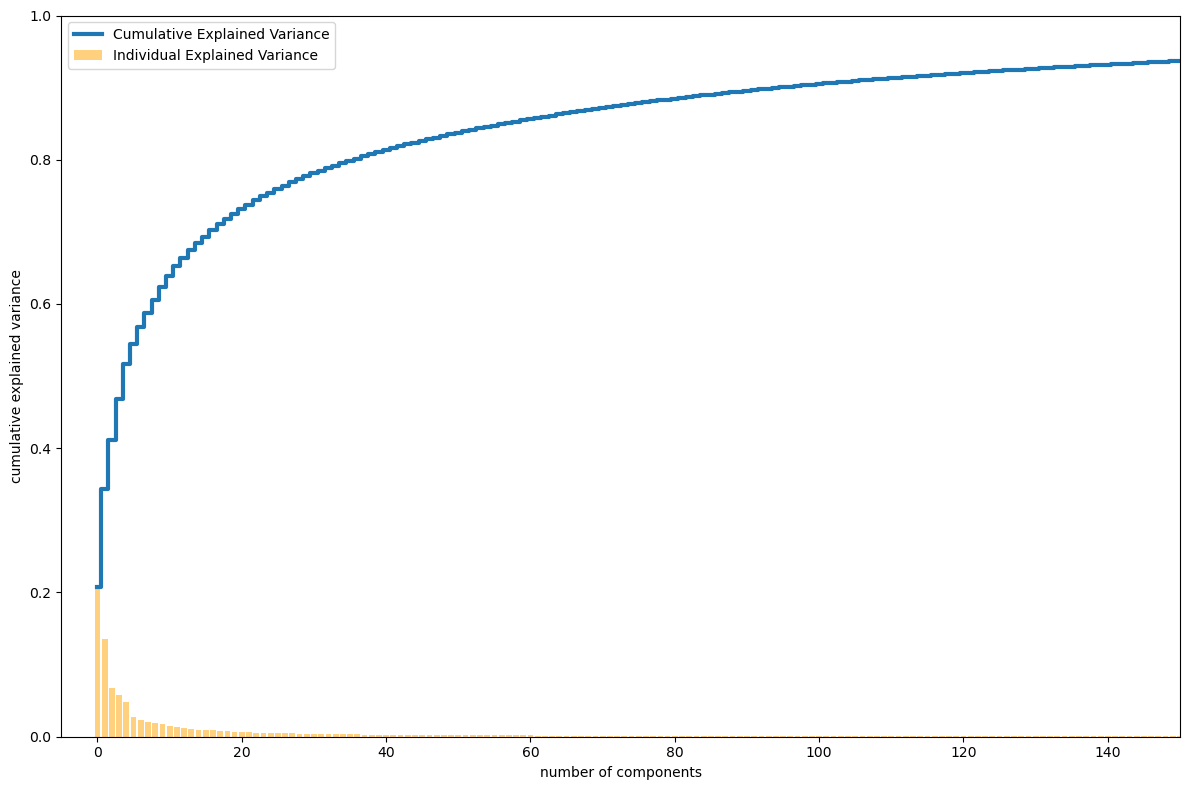

In [15]:
 plt.bar(range(0,len(explained_var_ratio)),explained_var_ratio,alpha=0.5,align='center',label='Individual Explained Variance',color='orange' )
 plt.step(range(0,len(cumul_sum_eigval)),cumul_sum_eigval,where='mid',label='Cumulative Explained Variance',linewidth=3.0)

 plt.xlabel('number of components')
 plt.ylabel('cumulative explained variance');
 plt.xlim(-5,n_comp)
 plt.ylim(0,1.0)
 plt.tight_layout()
 plt.legend(loc='best')
 plt.show()

############

The _first_ component by itself accounts for 20% of the variance and the second about 15% of the variance.   Evidently, lighting matters ... a lot.   Then we see a long tail of explained variance out beyond the 20th-30th principal component (roughly corresponding to the last image shown in the eigenface gallery above.   I.e. the PCs corresponding to the eigenfaces shown account for a lot (75% or so) of the variance in our entire sample. 

From this plot, we see that the 150 components account for about 90% of the variance.   If didn't truncate the number of PCs at all (i.e. numpca=1348), we will see that this line is nearly horizontal beyond about PC = 150.   That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data. To make this more concrete, we can compare the input images with the images reconstructed from these 150 components.

To do that, we then have to perform the inverse-transform of the principal components and add back the image mean: $\bar{x}est$ = $PC$*$V^{T}$ + mean($x$).

In [16]:
 #Step 6
 pca_inverse_transform=pca_components.dot(eig_vec.T)+np.mean(faces.data,axis=0)


Finally, we can compare these reconstructed images to the input images themselves.

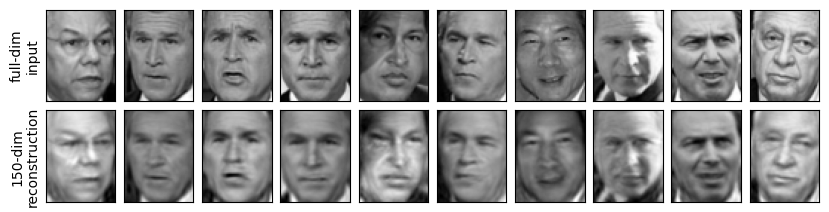

In [17]:
 #### Plotting the Real Images and PC-Projected Images
 fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
 for i in range(10):
     ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
     ax[1, i].imshow(pca_inverse_transform[i].reshape(62, 47), cmap='binary_r')

 ax[0, 0].set_ylabel('full-dim\ninput')
 ax[1, 0].set_ylabel(str(numpca)+'-dim\nreconstruction');

 plt.show()

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.  Although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image. What this means is that if we have a classification algorithm (Machine Learning jargon ... again, hopefully we cover this late), it needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

Now, what about a more aggressive cutoff in PCs?  How about, say, 40 principal components?   Can we still recognize people then?

Let's run this program ...


In [18]:
from code_ipynb.eigenfaces_np import run

(1348, 62, 47)


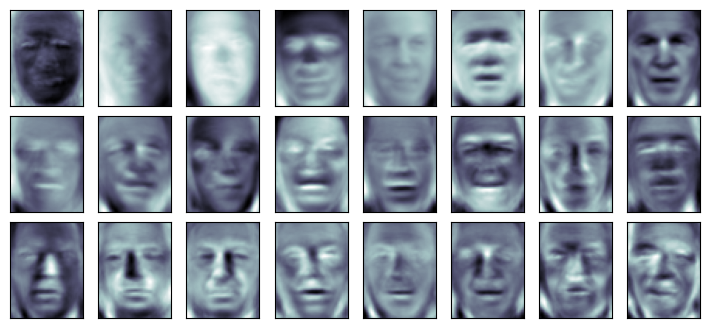

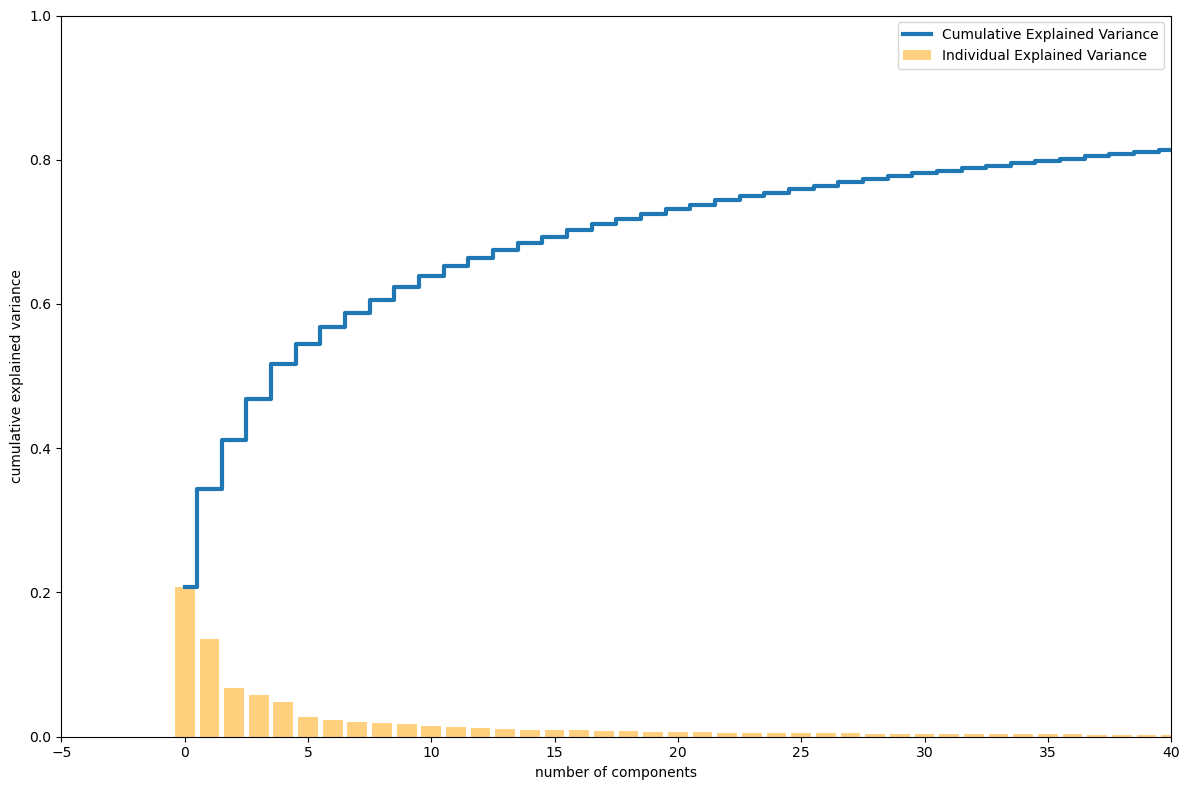

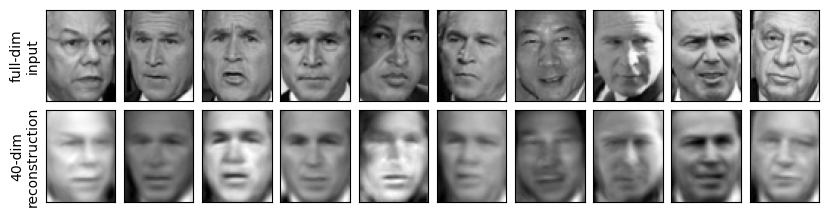

In [19]:
run(numpca=40)

Pretty much?   

Or where we just use the PCs we could see from our eigenface gallery (24 PCs):

(1348, 62, 47)


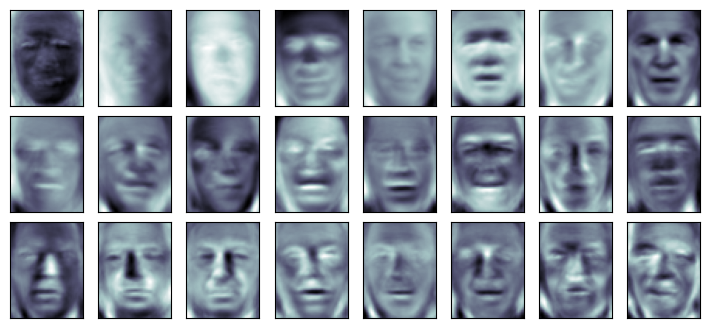

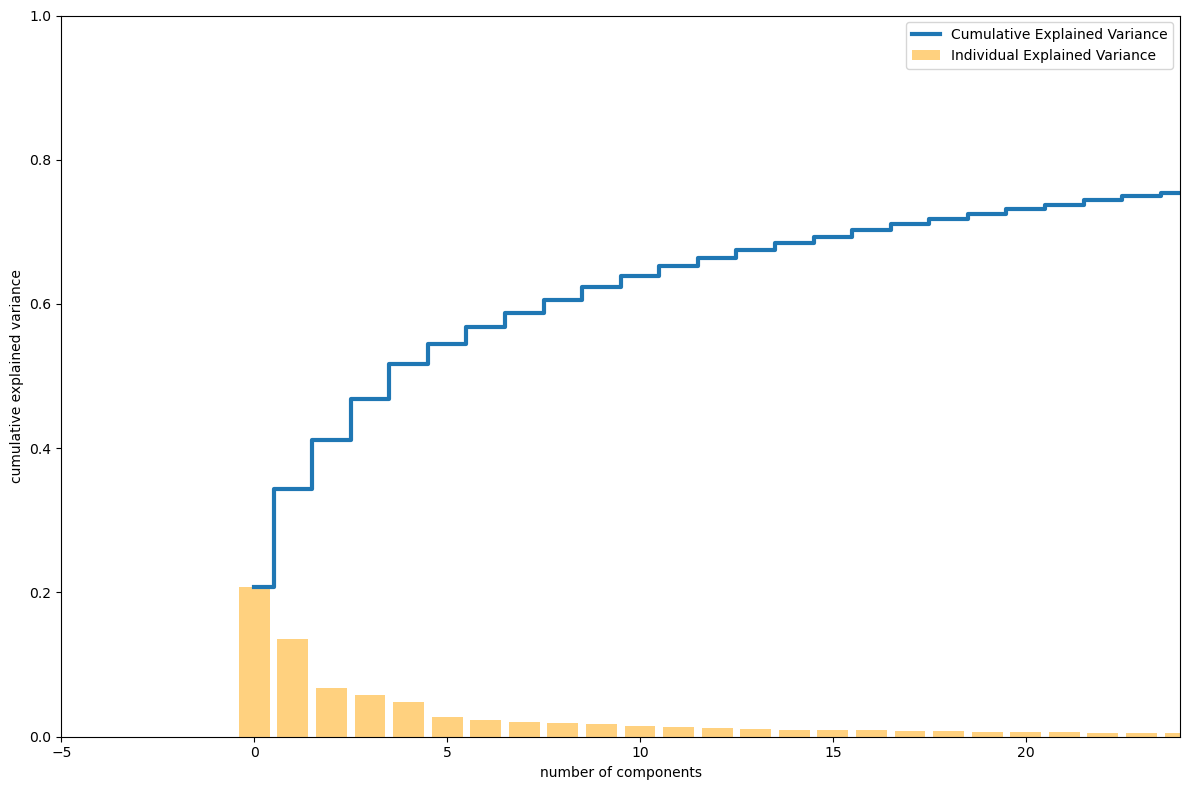

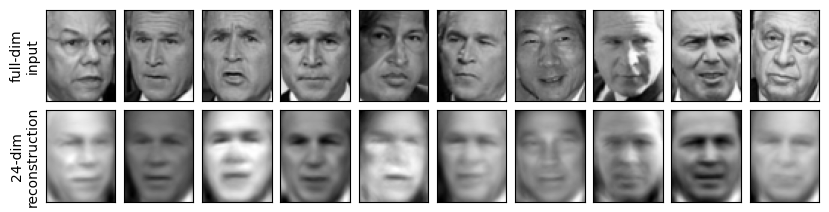

In [20]:
run(numpca=24)

Yes but it is harder in a few cases (e.g. see the confusion between George W Bush's face and Huge Chavez's face).   Still, we can see the qualitative point from quantitative metrics: a) we can explain 75-80% (90%) of the variance from the first 24-40 (150) principal components and b) images reconstructed from 24-40 (150) PCs give hints of the identity of the person whose image is depicted (clearly identify the person behind the images).

### 2. **PCA for Visualization**

Okay, enough of the creepy faces. 

PCA is used often for dimensionality reduction of large, N-dimensional data sets.  The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at _really_ high-dimensional data. 

To see this, we can look at another example from the scikit-learn package of datasets: one dealing with noisy digits.   The source code for this example is in ``pcadigits_np.py`` (the scikit-learn version is in ``pcadigits_sk.py``).   Like before, the code is executed as ``from pcadigits_np import run; run(numpca=[some number]``. 

This dataset is often used as a machine learning example ("random forests" ... don't worry about that for now), but we gain some insight into what PCA can do from analyzing these data.


In [21]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

(1797, 64)


The data consists of 8×8 pixel images, meaning that they are 64-dimensional.  There are 1797 images total.   The image below displays the first 64 or so:

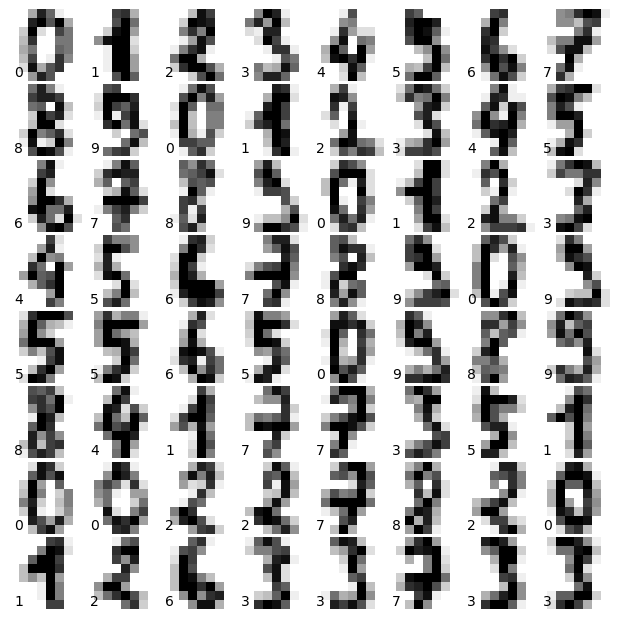

In [23]:
 fig = plt.figure(figsize=(6, 6))  # figure size in inches
 fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
 for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))
    ax.axis('off') 

 plt.show()


To gain some intuition into the relationships between these 8x8 points across our set of images, we can use PCA.  Doing so allows us to see more clearly how the digits (even noisy realizations of them) differ. 

Per usual, we perform the normal PCA steps:


```
#Step 1
 digits_mean=digits.data-np.mean(digits.data,axis=0)

#Step 2
 cov=np.matmul(digits_mean.T,digits_mean)

#Step 3
 eig_val,eig_vec=np.linalg.eigh(cov)

#Step 4
 indices=np.argsort(eig_val)[::-1]
 eig_val=eig_val[indices]
 eig_vec=eig_vec[:,indices]

#Step 5
 n_comp=numpca
 eig_vec=eig_vec[:,:numpca]
 eig_valtot=eig_val
 eig_val=eig_val[:numpca]

 pca_components=((digits_mean).dot(eig_vec))
```

Here, the code will run at full rank (i.e. all principal components retained). The full code is in ``pcadigits_np.py``.  As before, we break it up into pieces ...

(1797, 64)


/var/folders/jd/2nq0dfy94lsddczv0kg2y33h0000gn/T/ipykernel_69341/2811558584.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


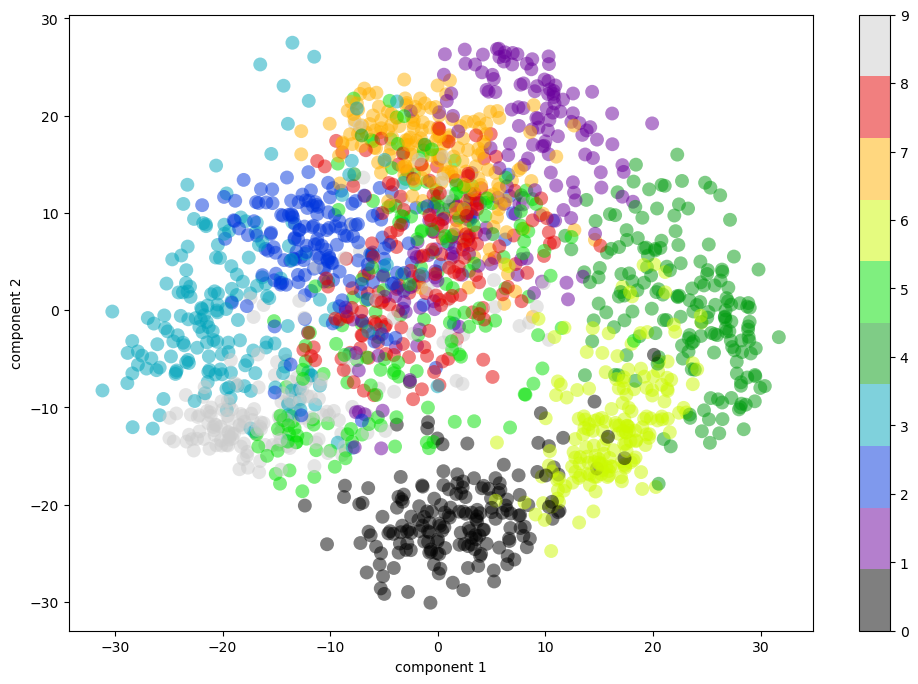

In [24]:
 digits=load_digits()
 print(digits.data.shape)
 numpca=digits.data.shape[1]


#Step 1
 digits_mean=digits.data-np.mean(digits.data,axis=0)

#Step 2
 cov=np.matmul(digits_mean.T,digits_mean)

#Step 3
 eig_val,eig_vec=np.linalg.eigh(cov)

#Step 4
 indices=np.argsort(eig_val)[::-1]
 eig_val=eig_val[indices]
 eig_vec=eig_vec[:,indices]

#Step 5
 n_comp=numpca
 eig_vec=eig_vec[:,:numpca]
 eig_valtot=eig_val
 eig_val=eig_val[:numpca]

 pca_components=((digits_mean).dot(eig_vec))

 plt.scatter(pca_components[:, 0], pca_components[:, 1],
             c=digits.target, edgecolor='none', alpha=0.5, s=100,
             cmap=plt.cm.get_cmap('nipy_spectral', 10))
 plt.xlabel('component 1')
 plt.ylabel('component 2')
 plt.colorbar()

 plt.show()

Okay, whoa what is this?  

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the two directions with the largest variance. 

We have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.  You can clearly see how the different digits separate along just two principal components.  E.g. 0's are fairly easy to identify as are 6's. 5's are a bit harder to identify from 8's and a few other numbers, occupying a large range of space in this plot.  

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset. The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series. 

We can again see the ability of just a few principal components to explain the data by plotting the cumulative explained variance of our data:

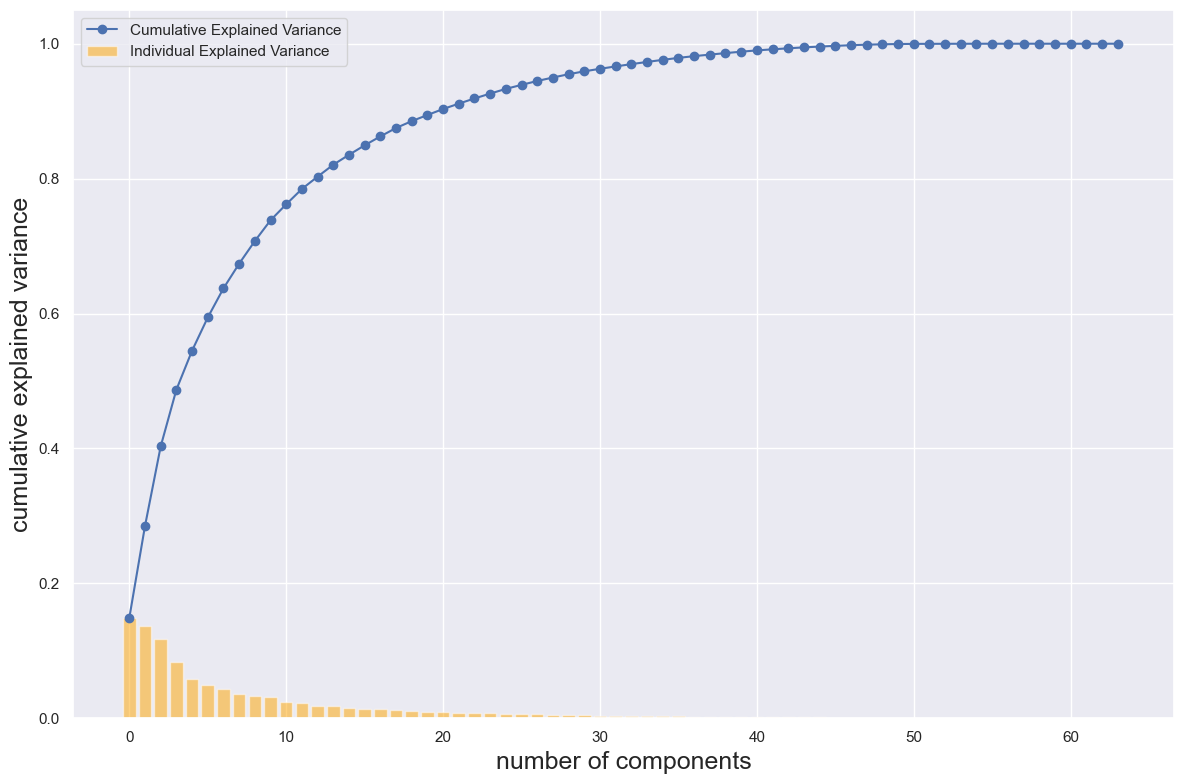

In [25]:
 import seaborn as sns; sns.set()
    ### Plotting the contribution of each PC to the total variance
 totvar=np.sum(eig_valtot)

 explained_var_ratio=eig_valtot/totvar

#Computing the Cumulative Variance of each eigenvector/PC

 plt.bar(range(0,len(explained_var_ratio)),explained_var_ratio,alpha=0.5,align='center',label='Individual Explained Variance',color='orange' )
 plt.plot(np.cumsum(explained_var_ratio),marker='o',label='Cumulative Explained Variance')
 plt.xlabel('number of components',fontsize=18)
 plt.ylabel('cumulative explained variance',fontsize=18)
 plt.legend(loc='best')
 plt.tight_layout()

 plt.show()

This figure shows a depiction of reconstructing the number 0 using the mean plus the first eight PCA basis functions, from calling the ``plot_pca_components`` function ...

In [26]:

from code_ipynb.pcadigits_np import plot_pca_components

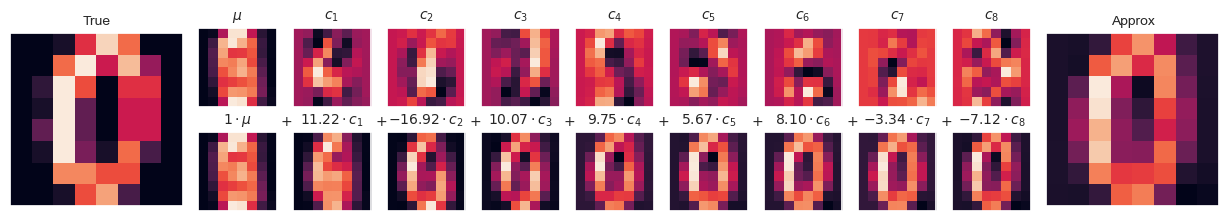

In [27]:
 fig = plot_pca_components(digits.data[10], pca_components[10],
                           np.mean(digits.data,axis=0), eig_vec.T)

# cmap = plt.get_cmap()
# print('g is ',cmap)
 
 plt.show()

Pretty good. Visually, by the 3rd PC you can identify this as a zero.

What about for a 5?

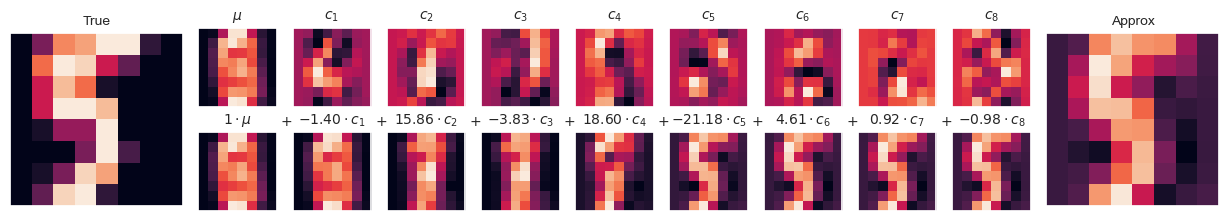

In [28]:
 fig = plot_pca_components(digits.data[15], pca_components[15],
                           np.mean(digits.data,axis=0), eig_vec.T)
    
    
 plt.show()   

We need more PCs to really be able to identify this as (likely) a 5.

### 3.  **PCA As Unsupervised Learning** 

Now, we can use PCA for Machine Learning (sorry that text is terse/absent, will explain why in class and update notes later)

In [29]:
#
from sklearn.model_selection import train_test_split

trainsize=100
#trainsize=1796
testsize=digits.data.shape[0]-trainsize

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,test_size=testsize,train_size=trainsize,
                                                random_state=42) #the random state is set just so you can reproduce the results cleanly

print(Xtrain.shape,ytrain.shape)
print(Xtest.shape)

print(ytrain[0:5])

print('We train our Support Vector Classifier on the PCA-Transformed Data for {0:d} Digits'.format(trainsize)) 
print('and Apply this on {0:d} Test Digits'.format(testsize))

(100, 64) (100,)
(1697, 64)
[0 9 3 7 5]
We train our Support Vector Classifier on the PCA-Transformed Data for 100 Digits
and Apply this on 1697 Test Digits


In [30]:

npca=50
from sklearn.decomposition import PCA
pca = PCA(n_components=npca, whiten=False)
pca.fit(Xtrain)
#X_red = pca.transform(resultt)

X_red=pca.transform(Xtrain)
X_red.shape

print('fitting {0:d} Principal Components'.format(X_red.shape[1]))

fitting 50 Principal Components


In [31]:
from sklearn.svm import SVC

In [32]:
linclass2 = SVC()
linclass2.fit(X_red,ytrain)

SVC()

/var/folders/jd/2nq0dfy94lsddczv0kg2y33h0000gn/T/ipykernel_69341/918975452.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


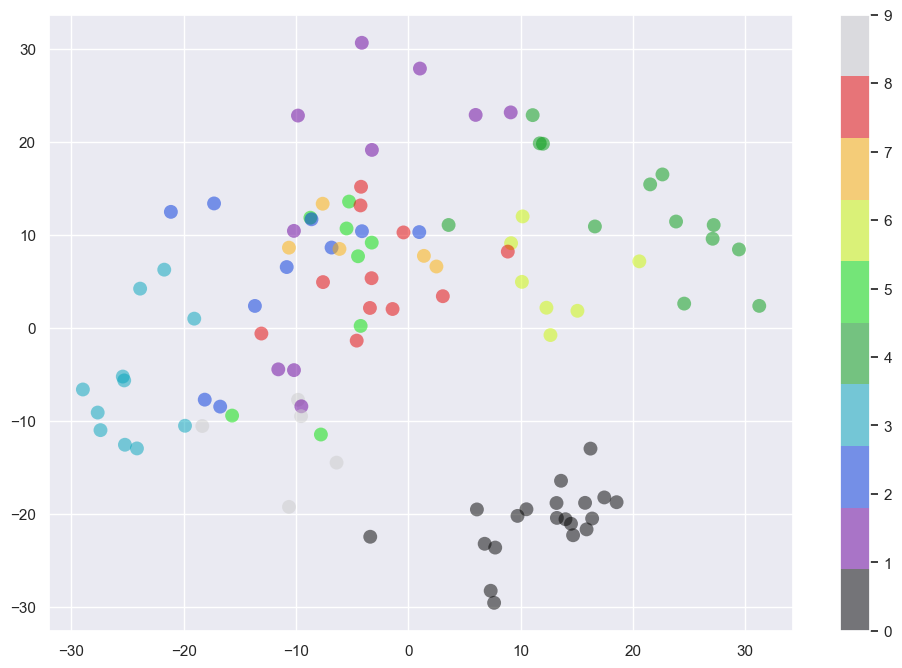

In [33]:
#now plot the scatter of stuff

plt.scatter(X_red[:,0], X_red[:,1],
#plt.scatter(X_red[:,1], X_red[:,4],
             c=ytrain, edgecolor='none', alpha=0.5, s=100,
             cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()

In [34]:
# Now see how good it is:
# Use the PCA to fit the validation data,
# then use the classifier to classify digits.
X_red_validation = pca.transform(Xtest)
yhat_validation = linclass2.predict(X_red_validation)

y_validation = ytest

y_validation.shape
ytest.shape

(1697,)

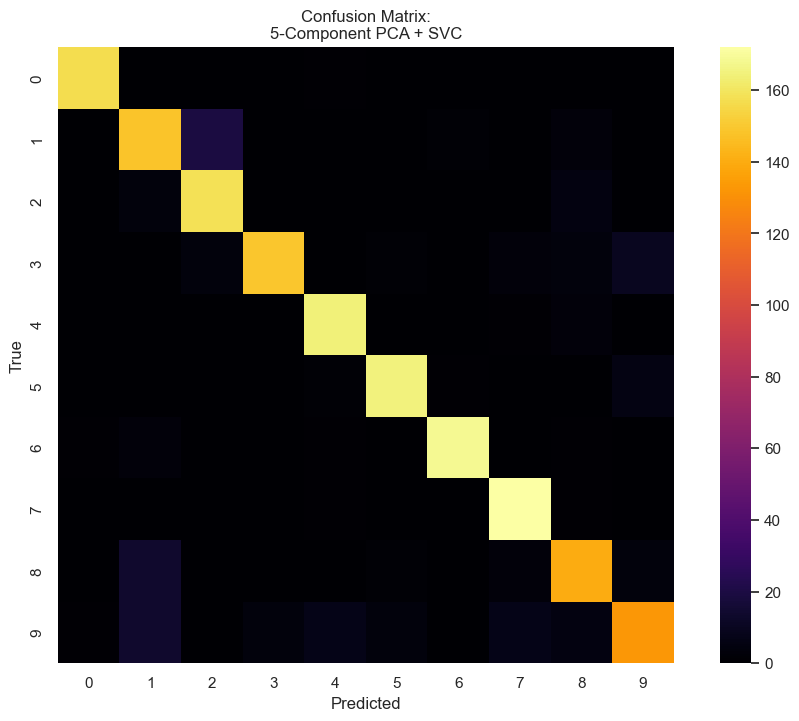

In [35]:
import seaborn as sns #seaborn does this well
from sklearn.metrics import confusion_matrix

pca_cm = confusion_matrix(y_validation,yhat_validation)
sns.heatmap(pca_cm, square=True, cmap='inferno')
plt.title('Confusion Matrix:\n5-Component PCA + SVC')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [36]:
total = pca_cm.sum(axis=None)
correct = pca_cm.diagonal().sum()
print("{0:d}-Component PCA Accuracy: {1:.2f}".format(npca,(100.0*correct/total)))

50-Component PCA Accuracy: 91.57


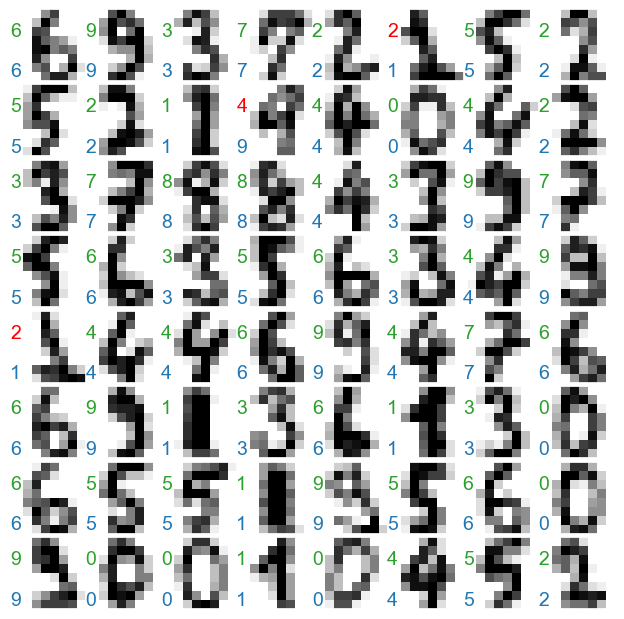

In [37]:
 # set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    #ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    ax.imshow(Xtest[i].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest',clim=(0,16))
    
    # label the image with the target value
    ax.text(-1, 7, str(ytest[i]),color='tab:blue',fontsize=14)
    if yhat_validation[i] == ytest[i]:
     ax.text(-1, 2.5, str(yhat_validation[i]),color='tab:green',fontsize=14)
    else:
     ax.text(-1, 2.5, str(yhat_validation[i]),color='red',fontsize=14)

plt.show()

(1797, 64)


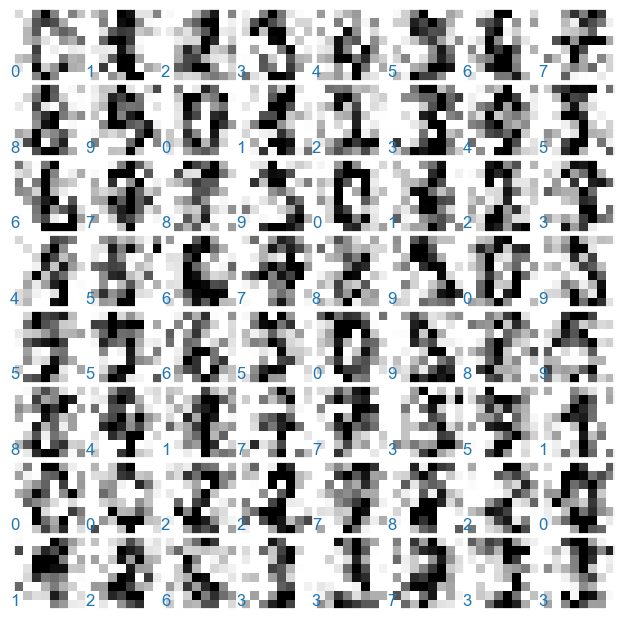

In [38]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 5)
#noisy=digits.data
print(noisy.shape)


fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(noisy[i].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest',clim=(0,16))

    # label the image with the target value
    ax.text(-1, 7, str(digits.target[i]),color='tab:blue')

plt.show()

In [39]:
Xtrainnoisy, Xnoisy, ytrainnoisy, ytestnoisy = train_test_split(noisy, digits.target,test_size=testsize,train_size=trainsize,
                                                random_state=42) #the random state is set just so you can reproduce the results cleanly

In [40]:
linclass3 = SVC()
linclass3.fit(X_red,ytrain)

SVC()

In [41]:
X_red_validationnoisy = pca.transform(Xnoisy)
yhat_validationnoisy = linclass3.predict(X_red_validationnoisy)


#X_red_validation = pca.transform(Xtest)
#yhat_validation = linclass2.predict(X_red_validation)

y_validationnoisy = ytestnoisy

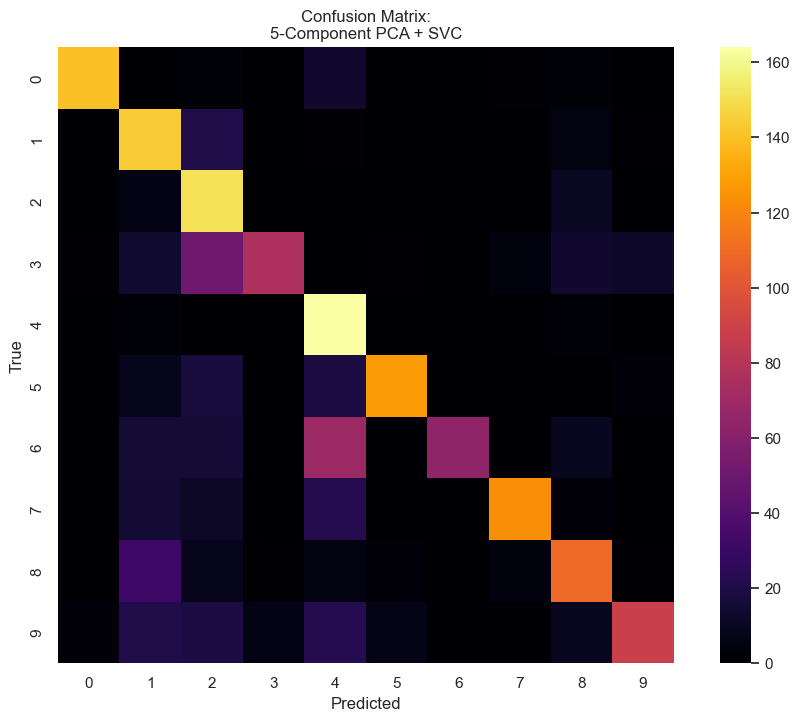

In [42]:



pca_cmnoisy = confusion_matrix(y_validationnoisy,yhat_validationnoisy)
sns.heatmap(pca_cmnoisy, square=True, cmap='inferno')
plt.title('Confusion Matrix:\n5-Component PCA + SVC')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [43]:
total = pca_cmnoisy.sum(axis=None)
correct = pca_cmnoisy.diagonal().sum()
print("{0:d}-Component PCA Accuracy: {1:.2f}".format(npca,(100.0*correct/total)))
  #    %0.2f %%"%(100.0*correct/total))

50-Component PCA Accuracy: 70.01


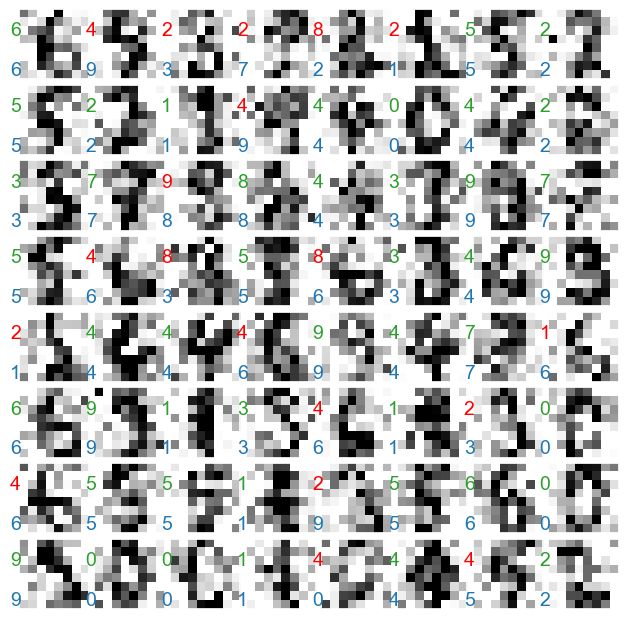

In [44]:
 # set up the figure
#y_validationnoisy
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.075, wspace=0.075)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8,8, i + 1, xticks=[], yticks=[])
    #ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    ax.imshow(Xnoisy[i].reshape(8,8), cmap=plt.cm.binary, interpolation='nearest',clim=(0,16))
    
    # label the image with the target value
    ax.text(-1.5, 7, str(y_validationnoisy[i]),color='tab:blue',fontsize=14)
    #if yhat_validationnoisy[i] == ytestnoisy[i]:
    if yhat_validationnoisy[i] == y_validationnoisy[i]:
     ax.text(-1.5, 2.5, str(yhat_validationnoisy[i]),color='tab:green',fontsize=14)
    else:
     ax.text(-1.5, 2.5, str(yhat_validationnoisy[i]),color='red',fontsize=14)

plt.show()

### 4.  **Exoplanet Imaging** 

 There's another application of PCA that is particularly interesting.

Remember back a few lectures ago when we were solving least-squares problems and came up with the "Locally Optimized Combination of Images" algorithm?  That was a straight matrix inversion multiplied by a column vector to give you a set of coefficients useful for minimizing the noise in an image (and hopefully detecting a planet).  

What I didn't tell you then is that the **A** matrix in the **Ax** = **b** equation there is actually the covariance matrix.   We discussed earlier how we can truncate the covariance matrix using SVD to modify the LOCI algorithm.   Well, we can do a slightly different approach entirely: constructing a reference image to subtract from our target image where that reference consists of a linear combination of _eigenimages_.

Principal Component Analysis forms the backbone of this approach too.   What we do is that we take the basis set (jargon jargon basically the PCs) and _transform_ it.  In the research literature, we call this new matrix $Z_{k}^{KL}$:

$Z_{k}^{KL}$ = $PC$/$\sqrt{\Lambda}$


 and then taking the dot product with a target image and multiplying the target image again.   It looks like this:

$<$($Z_{k}^{KL}$,$T$) $>$ $Z_{k}^{KL}$

(note: here in linear algebra hieroglyphics, the $<$ , $>$ means "dot product").  

So what is this?  Well, remember when we originally did data-eigenvector multiplication we can think of it as "transforming" the data to a new basis set?   Well this equation has its own special term: the _Karhunen-Loeve transform_.   The algorithm name is the _Karhunen-Loeve Image Projection_ algorithm or "KLIP" for short.

At full rank (i.e. you don't truncate anything), this is mathematically equivalent to LOCI. 

Below is an example image of an exoplanet with PCA/KLIP.

![](./figures/pcaexample.png) 

You can also use PCA to remove thermal background from images in some cases.   Ground-based imaging of exoplanets is usually done in the infrared where planets are bright but also the sky is much brighter than it is in the optical.   In _thermal_ infrared passbands (e.g. 3 to 5 microns) the sky is _particularly_ bright.   And that "sky background" also varies in brightness on the order of minutes to tens of minutes or so.   

The usual way to remove sky background is through simple "sky subtraction" (i.e. you move the star around the image, take a median-combination of those dithered images, subtract this "sky" image from each of your target images).   

Below is an example:

![](./figures/bckgdpca1.png)

As you can see, the residual sky background has a lot of structure.  Maybe we can clean it up better?

The answer is to actually use principal component analysis to model and remove the sky background as described in Hunziker et al. (2018).  If you have a bunch of sky images taken in short sequences, you can do this.  First, remove the mean sky level from each frame.  Then combine the sky frames into a matrix of $m$ images by $n$ pixels.   There's some other trickery you have to do (e.g. masking out the star/probable planet location), but the basic consequence is that you can model the sky background a lot better.  Below is an example of the same sky background as above in principal component "space"

![](./figures/bckgdpca2a.png)
![](./figures/bckgdpca2b.png)

You then project these PCs onto each image to flatten the sky background.

![](./figures/bckgdpca3.png)

---

... and we are done talking about principal component analysis.   It may have seen like a rabbit hole, but I hope to have convinced you the PCA is very powerful.  PCA talked about widely within the context of Machine Learning as an "unsupervised learning" technique.  We will not get to Machine Learning in this class, but if you are interested then Van der Plas's data science textbook is a good starting point.   